In [2]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('Feb23_summtab.csv')
alls = pd.read_csv('current_summ.csv') #most updated table from before Feb23 restart

phase = pd.read_csv('Feb23_phasetab.csv')
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

#set plot styles
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 9
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.2

mpl.rcParams['ytick.major.size'] = 9
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['ytick.right'] = True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True

mpl.rcParams['xtick.top'] = True

#dictionaries to get new source numbers and names from old source numbers
src_dict = dict(zip(np.array(alls['src_n']), np.array(alls['new src_n'])))
reverse_src_dict = dict(zip(np.array(alls['new src_n']), np.array(alls['src_n'])))
name_dict = dict(zip(np.array(summ['src_n']), np.array(summ['name'])))

calibration_used = [7, 23, 34, 42, 54, 60, 62, 63, 64, 68, 69, 70, 71, 73, 74, 79, 84, 87, 91,105,106,107] #new type numbers

In [3]:
type5 = o.gettype(summ,num='5')
type6 = o.gettype(summ,num='6')

In [4]:
def sig_detrend(iband): #detrending method used in Mar23_Types
    flatten,trend,idet = o.splinedetrend(iband,window=200,retspline=True,rettemp=True)
    original_std = np.nanstd(iband['I mag'])
    detrended_std = np.nanstd(idet['I detrend'])
    imag = iband['I mag']
    
    median_i = np.nanmedian(imag) 
    imag[imag<median_i-10*original_std] = np.nan
    imag[imag>median_i+10*original_std] = np.nan
    original_std = np.nanstd(imag)
        
    detrended = idet['I detrend']
    detrended_median = np.nanmedian(detrended)
    detrended[detrended<detrended_median-5*detrended_std] = np.nan
    detrended[detrended>detrended_median+5*detrended_std] = np.nan
    detrended_std = np.nanstd(detrended)
    return detrended_std/original_std

def find_ratio(iband,start,length=500):
    #get chunk of some length
    chunk = iband[iband['MJD-50000']>start]
    chunk = chunk[chunk['MJD-50000']<start+length]
    #detrend chunk
    try:ratio = sig_detrend(chunk)
    except: ratio = np.nan 
    return ratio

def plot(s):
    if src_dict[s] in calibration_used:calib=True
    else:calib=False
    try: iband, vband = o.getIV(s,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3),calib=calib)
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3),calib=calib)

In [21]:
def find_quiescent_parts(iband,length=500,step=50,src=0,plotlc=False,retratio=False,minq=1000,c=1,maxiter=3):
    '''
    length: length of chunk to check for ratio
    step: stepsize to next chunk (step<length)
    '''
    if src>0:
        if src_dict[src] in calibration_used:calib=True
        else:calib=False
        try:iband = o.getIV(src,cross,stack=True,both=False,calib=calib)
        except:iband = o.getIV(src,cross2,mlist=mlist2,stack=True,both=False,calib=calib)
    start = iband['MJD-50000'][0]
    end = iband['MJD-50000'][-1]
    qui = False
    ctime = start
    min_type5 = 0.40
    
    while not qui and ctime<end:
        ratio = find_ratio(iband,ctime,length=length)
        if ratio>min_type5:
            qui = True #start of quiescence
            qstart = ctime
        else: ctime+=length
    #if never starts quiescence
    if not qui and retratio: return np.nan,np.nan,np.nan,np.nan
    elif not qui: return np.nan,np.nan
    ctime = qstart 
    while qui and ctime<end:
        ratio1 = find_ratio(iband,ctime,length=length)
        #also check using whole quiescent part thus far
        ratio2 = find_ratio(iband,qstart,length=ctime-qstart+length)
        if ratio1<min_type5 or ratio2<min_type5: 
            qui=False #not quiescent
        else: ctime+=step
    if plotlc:
        if src>0:plot(src)
        else: 
            plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
            if c==1: plt.ylim(np.max(iband['I mag'])+.1,np.min(iband['I mag'])-.1)
        plt.axvspan(qstart,ctime,alpha=0.1)
    #run again
    if ctime-qstart<minq:
        while ctime-qstart<minq and c<maxiter: #iterate a couple times more at most, or stop when quiescent part longer
            c+=1
            #and pass in iband with shortened iband
            short = iband[iband['MJD-50000']>ctime]
            if len(short)>0: qstart,ctime = find_quiescent_parts(short,length=length,step=step,src=0,plotlc=plotlc,retratio=False,minq=minq,c=c)
    if retratio: #also return stdev ratio and kurtosis
        if ctime-qstart<minq:return qstart,ctime,np.nan,np.nan
        qchunk = iband[iband['MJD-50000']>=qstart]
        qchunk = qchunk[qchunk['MJD-50000']<=ctime]
        try:
            ratio = sig_detrend(qchunk)
        except: ratio = np.nan
        return qstart,ctime,ratio,st.kurtosis(qchunk['I mag'])
    return qstart,ctime #start and end times of quiescence

In [24]:
def sources(start=0,end=20):
    for s in summ['src_n'][start:end]:
        row = summ[summ['src_n']==s]
        if src_dict[s] in calibration_used: calib=True
        else: calib = False
        if int(s) in type5 or int(s) in type6: 
            #automatically set to duration and to ratio and kurtosis already in table
            try:iband,vband = o.getIV(s,cross,both=True,stack=True,calib=calib)
            except:iband,vband = o.getIV(s,cross2,mlist=mlist2,both=True,stack=True,calib=calib)
            end = float(iband['MJD-50000'][-1])
            start = float(iband['MJD-50000'][0])
            kurt = row['I kurtosis']
            ratio = row['sig stdev ratio']
        else:
            start,end,ratio,kurt = find_quiescent_parts([],src=s,plotlc=True,retratio=True)
            plt.show()
            try:iband,vband = o.getIV(s,cross,both=True,stack=True,calib=calib)
            except:iband,vband = o.getIV(s,cross2,mlist=mlist2,both=True,stack=True,calib=calib)
            iband = iband[iband['MJD-50000']>=start]
            vband = vband[vband['MJD-50000']>=start]
            iband = iband[iband['MJD-50000']<=end]
            vband = vband[vband['MJD-50000']<=end]
        try:
            interp = i_interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
            vi = vband['V mag'] - interp
            vband['V-I'] = vi; vband['I'] = interp
            row['q V-I'] = np.mean(vband['V-I'])
            row['q I'] = np.mean(vband['I'])
            row['Ierr'] = np.std(vband['I'])  
            row['V-Ierr'] = np.std(vband['V-I'])
        except:
            row['q V-I'] = np.nan
            row['q I'] = np.nan
            row['Ierr'] = np.nan
            row['V-Ierr'] = np.nan
        row['qdur'] = end-start
        row['ratio'] = ratio
        row['kurt'] = kurt
        summ[summ['src_n']==s] = row

In [36]:
summ['qdur'] = [np.nan]*len(summ)
summ['ratio'] = [np.nan]*len(summ)
summ['kurt'] = [np.nan]*len(summ)
summ['q I'] = [np.nan]*len(summ)
summ['q V-I'] = [np.nan]*len(summ)
summ['Ierr'] = [np.nan]*len(summ)
summ['V-Ierr'] = [np.nan]*len(summ)

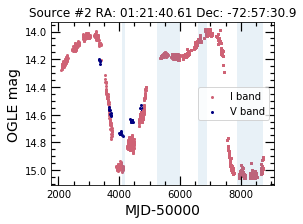

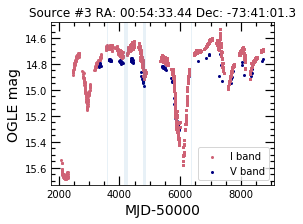

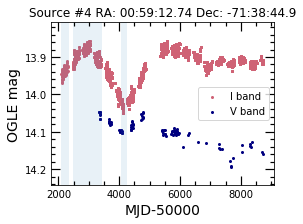

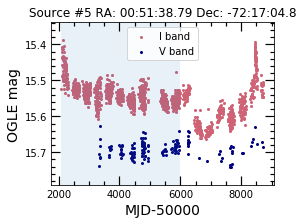

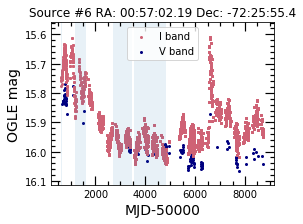

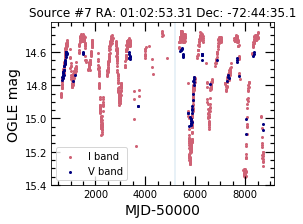

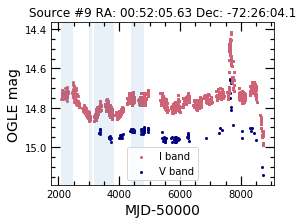

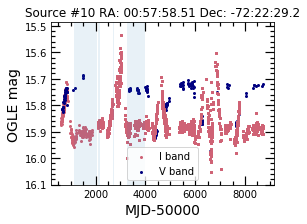

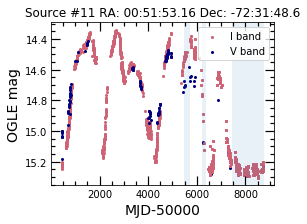

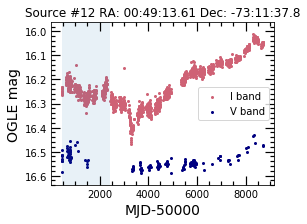

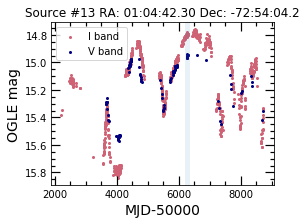

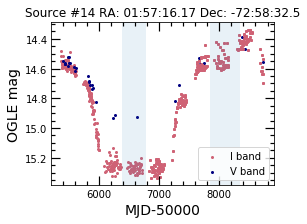

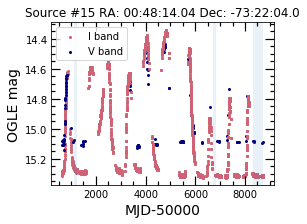

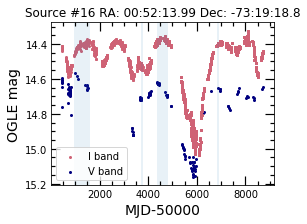

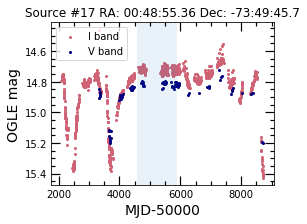

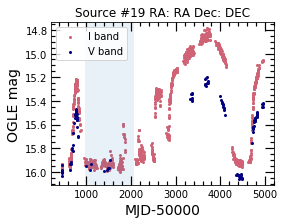

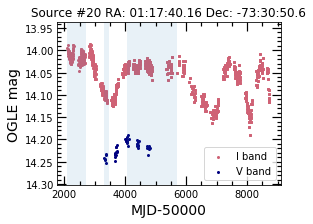

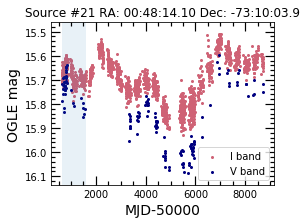

In [37]:
sources(start=1,end=20)

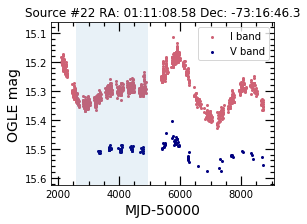

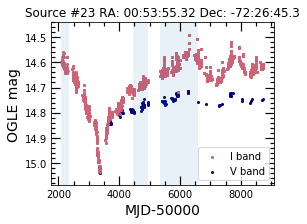

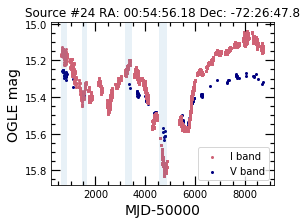

empty file for OIII I


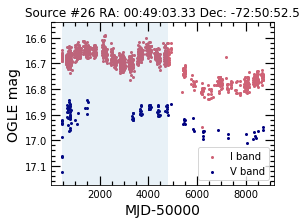

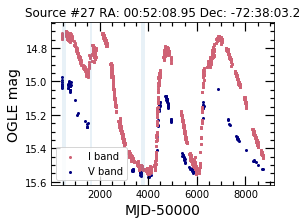

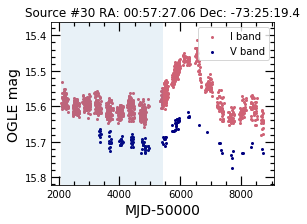

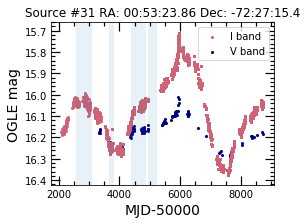

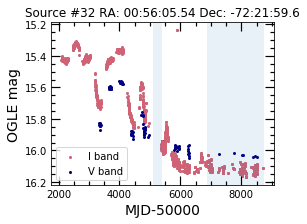

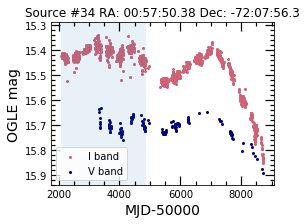

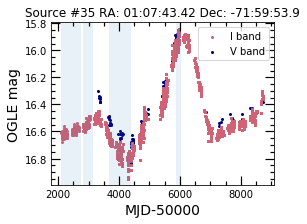

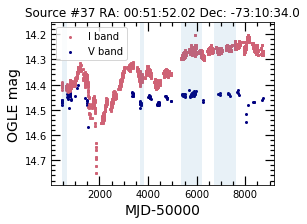

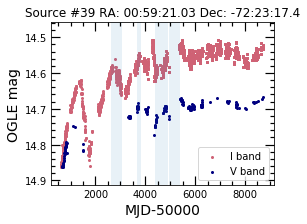

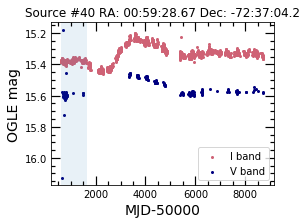

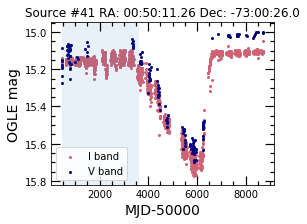

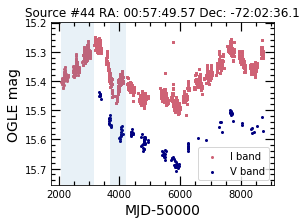

In [38]:
sources(start=20,end=40)

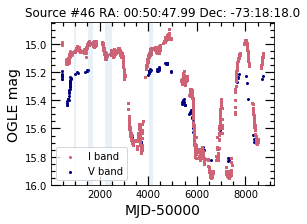

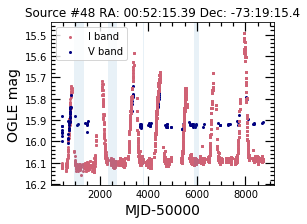

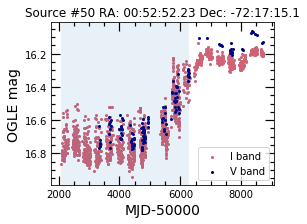

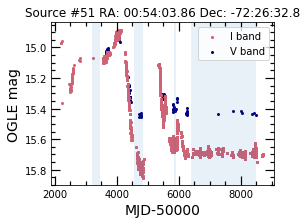

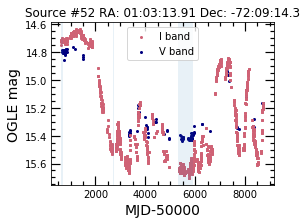

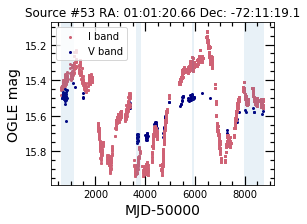

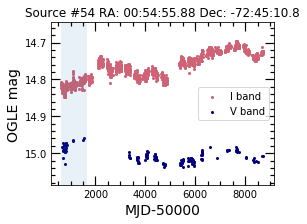

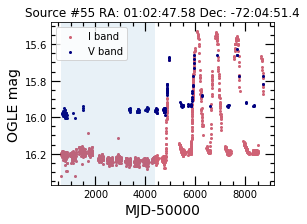

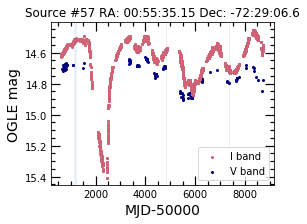

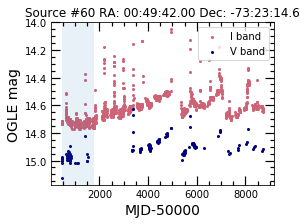

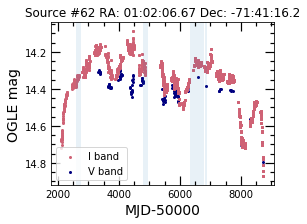

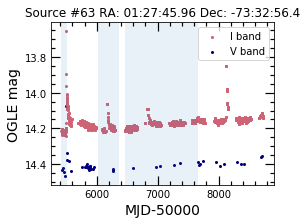

In [39]:
sources(start=40,end=60)

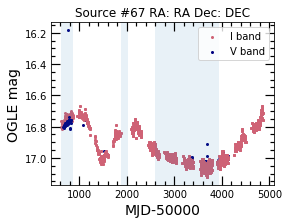

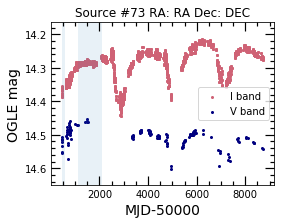

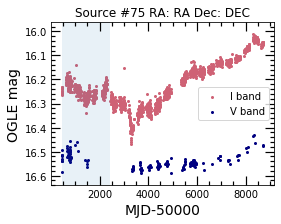

empty file for OII I


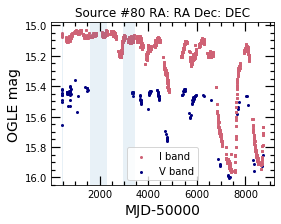

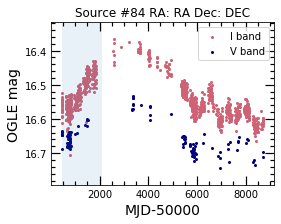

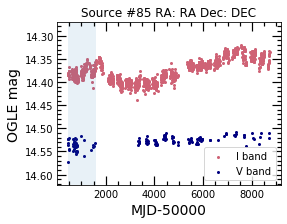

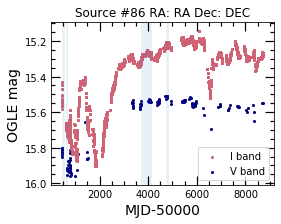

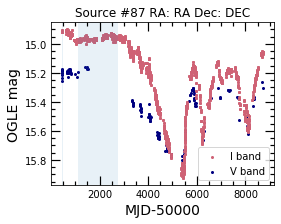

In [40]:
sources(start=60,end=80)

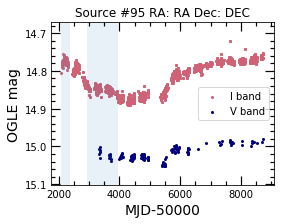

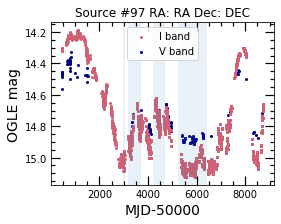

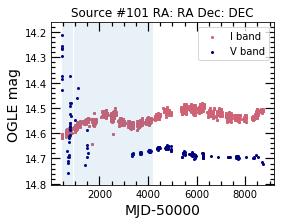

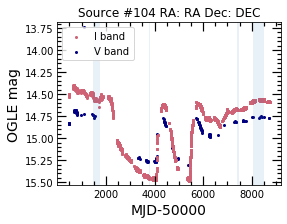

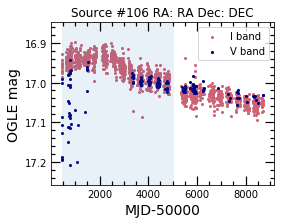

empty file for OIII I


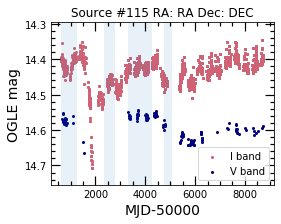

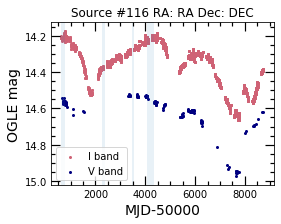

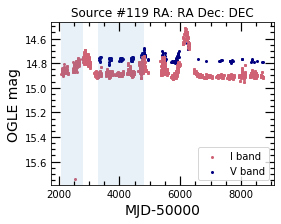

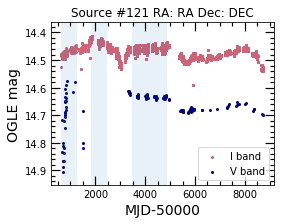

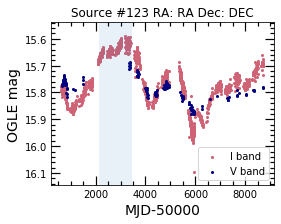

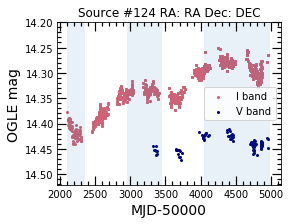

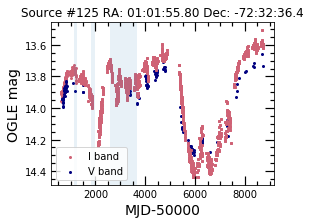

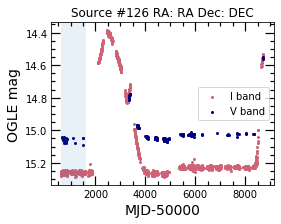

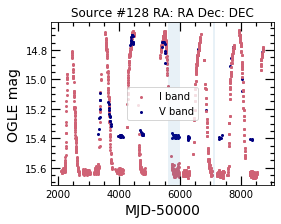

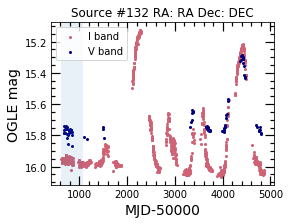

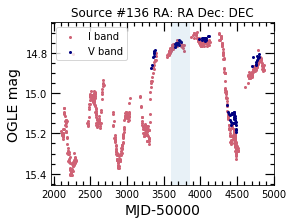

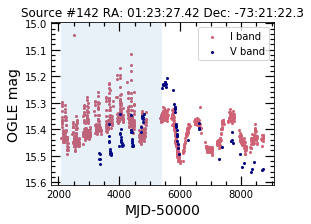

In [41]:
sources(start=80,end=109)

In [42]:
long = summ[summ['qdur']>1000]

typet = []
for i in range(len(summ)):
    row = summ.iloc[i]
    src = row['src_n']
    if '+' in str(row['type']):
        typet.append(int(src))
type1 = o.gettype(summ,num='1')
type2 = o.gettype(summ,num='2')
type3 = o.gettype(summ,num='3')
type4 = o.gettype(summ,num='4')

In [43]:
def fulltplot(x='stdev I',y='det stdev I',legend=True,tbool=[False]*6,between=False,tab=alls):
    if between and len(tbool)==6: tbool.append(False) #make sure tbool is right length 
    o.tplot(type1,tab,color=pink,marker='*',label='1',x=x,y=y,text=tbool[0])
    o.tplot(type2,tab,color='black',label='2',x=x,y=y,text=tbool[1])
    o.tplot(type3,tab,marker='v',label='3',color='maroon',x=x,y=y,text=tbool[2])
    o.tplot(type4,tab,color='rebeccapurple',marker='P',label='4',x=x,y=y,text=tbool[3])
    o.tplot(type5,tab,marker='3',label='5',color='grey',x=x,y=y,text=tbool[4])
    o.tplot(type6,tab,color='darkseagreen',marker='h',label='6',x=x,y=y,text=tbool[5])
    #if between, also plot transition sources
    if between: o.tplot(typet,tab,marker='p',label='transition',color='navy',x=x,y=y,text=tbool[6])
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()

In [52]:
highratio = summ[summ['ratio']>.77]#cutoff for type 6
non6_highratio = highratio[highratio['type']!='6']
print(np.array(non6_highratio['src_n']),np.array(non6_highratio['qdur']))
print(np.array(non6_highratio['type']))
len(non6_highratio)/(len(long)-len(type5)-len(type6))

[ 17  20  30  32  51 121 126] [1300. 1650. 3350. 1850. 2100. 1400. 1000.]
['2' '3' '3' '5+6' '+' '3' '1']


0.1891891891891892

In [88]:
np.array(non6_highratio['2-200d period above FAL?']) #3/7 aperiodic according to definition below

array(['yes', 'yes', 'yes', 'no', 'yes', 'no', 'no'], dtype=object)

#### the quiescent parts (i.e., min 1000 days) for seven sources are as quiescent as type 6 sources
- i.e., 19% of sources with "quiescent" region

In [67]:
#notice over-representation of types 4 and 6 at high spin periods
np.array(summ[summ['spin period']>700]['type'])

array(['6', '6', '4', '5', '2', '4', '6', '5'], dtype=object)

# Relationship Between Quiescence and Aperiodicity
- of the (21) sources without a 2-200d periodicity above the false alarm level, 71% are type 6
- among those (21) aperiodic sources, only four have established spin periods

In [83]:
aperiodic = summ[summ['2-200d period above FAL?']=='no'][1:]
print(np.array(aperiodic['type']))
print(len(aperiodic))
print(len(aperiodic[aperiodic['spin period']>0]))

['6' '5+6' '6' '6' '6' '6' '6' '6' '6' '5' '6' '6' '6' '6' '3' '6' '3' '1'
 '1' '6' '6']
21
4


In [94]:
#probably don't want category of transition sources; doesn't make a lot of sense
# for i in typet:plot(i)

# Periodicity in Quiescent Regions of Sources?
- also should be encapsulated in Period by Year analysis but consolidated here for relevant sources, more exact durations

In [157]:
def quiescent_periodicity(src,plotlc=False,colors = ['#A23F53','#4D74A8','#6D6878']): #compare periodicity search and phase-fold in and out of quiescent parts
    nsrcn = src_dict[src]
    name = name_dict[src]
    if nsrcn in calibration_used: calib=True
    else: calib = False
    try: iband = o.getIV(src,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=calib,both=False)
    except: iband = o.getIV(src,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=calib,both=False)
    iband = o.splinedetrend(iband,rettemp=True)
    qui_start,qui_end = find_quiescent_parts([],src=src,plotlc=plotlc)
    if plotlc:plt.show()
        
    same_start = iband['MJD-50000'][0]==qui_start
    same_end = iband['MJD-50000'][-1]==qui_end
    
    #separate quiescent and non-quiescent into two tables
    if same_start:
        qui_table = iband[iband['MJD-50000']<qui_end]
        nonqui_table = iband[iband['MJD-50000']>=qui_end]
        fig = periodicity_figure([qui_table,nonqui_table],colors=colors)
    elif same_end:
        qui_table = iband[iband['MJD-50000']>=qui_start]
        nonqui_table = iband[iband['MJD-50000']<=qui_start]
        fig = periodicity_figure([qui_table,nonqui_table],colors=colors)
    else: 
        qui_table = iband[iband['MJD-50000']>=qui_start]
        qui_table = iband[iband['MJD-50000']<=qui_end]
        before_table = iband[iband['MJD-50000']<qui_start]
        after_table = iband[iband['MJD-50000']>qui_end]
        if len(before_table)>300 and len(after_table)>300:fig = periodicity_figure([qui_table,before_table,after_table],colors=colors)
        else: #combine
            nonqui_table = vstack([before_table,after_table])
            fig = periodicity_figure([qui_table,nonqui_table],colors=colors)
        
    if len(str(name))>3:title = f'{name} (Source #{nsrcn})'
    else: title = f'Source #{nsrcn}'
    fig.suptitle(title, fontsize=18)
    plt.show()

In [165]:
#functionality to do three tables but only two best periods since currently no need for the three tables anyway

def periodicity_figure(tables,colors=['#A23F53','#4D74A8','#6D6878'],linestyles=['solid','dashed','dotted']): #used in quiescent_periodicity()
    fig,ax = plt.subplots(1,3,figsize=(24,5))
    ax[0].set_ylabel('LS Power',fontsize=16)
    ax[1].set_ylabel('Detrended I mag',fontsize=16)
    ax[0].set_xlabel('Period (days)',fontsize=16)
    
    
    #loop through tables and add periodogram and phase-folded results
    plt.subplots_adjust(wspace=0.18)
    
    #choose labels
    if len(tables)==2: labels = ['quiescent part','non-quiescent part']
    elif len(tables)==3: labels = ['quiescent part','before quiescent part','after quiescent part']
    maxes1,mins1 = [],[]
    maxes2,mins2 = [],[]
    best_periods = []
    for i in range(len(tables)):
        freq, power, bp, fal = o.periodogram(tables[i],det=True,more=True,minp=2,maxp=200,fal=0.001,plot=False)
        ax[0].plot(1/freq,power,color=colors[i],ls=linestyles[i],label=labels[i],alpha=0.7)
        ax[0].axhline(fal,color=colors[i],ls=linestyles[i],alpha=0.3)
        best_periods.append(bp)
    #fold with best period from each
    for i in range(len(tables)): 
        mid,avg,err = o.meanphase(tables[i],best_periods[0],pbins=16,det=True,double=True,stdev=True,divide=True,sterr=True)
        ax[1].step(mid,avg,where='mid',color=colors[i],ls=linestyles[i])
        #add errors as one sigma
        ax[1].errorbar(mid,avg,yerr=err,color=colors[i],marker='',linestyle='none',alpha=0.4)
        #flip y axis 
        maxes1.append(np.nanmax(avg)+err[np.nanargmax(avg)])
        mins1.append(np.nanmin(avg)-err[np.nanargmin(avg)])
        
        mid,avg,err = o.meanphase(tables[i],best_periods[1],pbins=16,det=True,double=True,stdev=True,divide=True,sterr=True)
        ax[2].step(mid,avg,where='mid',color=colors[i],ls=linestyles[i])
        #add errors as one sigma
        ax[2].errorbar(mid,avg,yerr=err,color=colors[i],marker='',linestyle='none',alpha=0.4)
        #flip y axis 
        maxes2.append(np.nanmax(avg)+err[np.nanargmax(avg)])
        mins2.append(np.nanmin(avg)-err[np.nanargmin(avg)])
        
    maxi = np.max(maxes1)
    mini = np.min(mins1)
    ax[1].set_ylim(maxi+.003,mini-.003)
        
    maxi = np.max(maxes2)
    mini = np.min(mins2)
    ax[2].set_ylim(maxi+.003,mini-.003)
    
    ax[1].set_xlabel(f'Phase ({best_periods[0]:.2f}d)',fontsize=16)
    ax[2].set_xlabel(f'Phase ({best_periods[1]:.2f}d)',fontsize=16)
    ax[0].legend()
    
    return fig

In [155]:
qui = summ[summ['qdur']>2000]
qui = qui[qui['type']!='5']
qui = qui[qui['type']!='6']
len(qui)

12

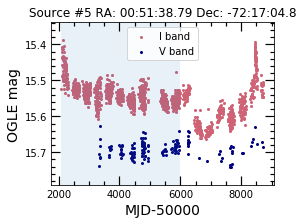

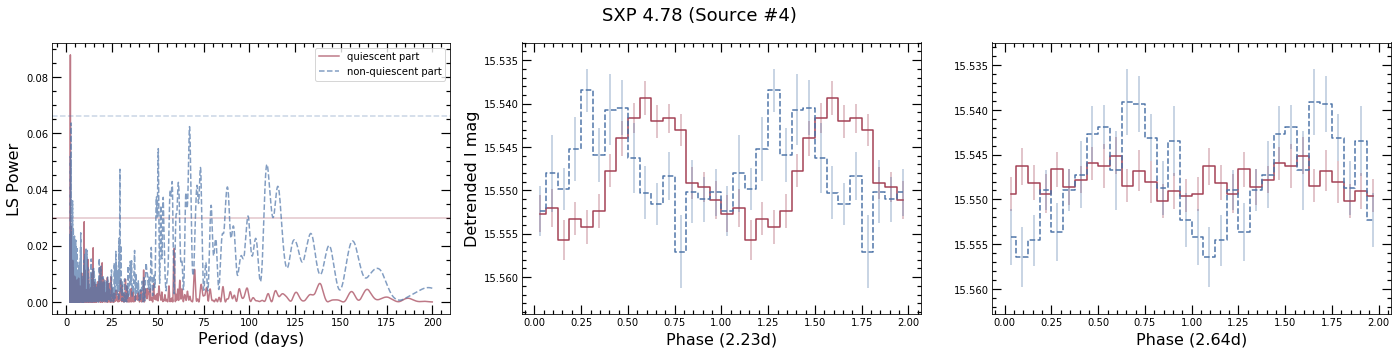

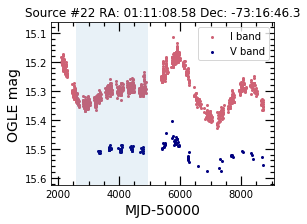

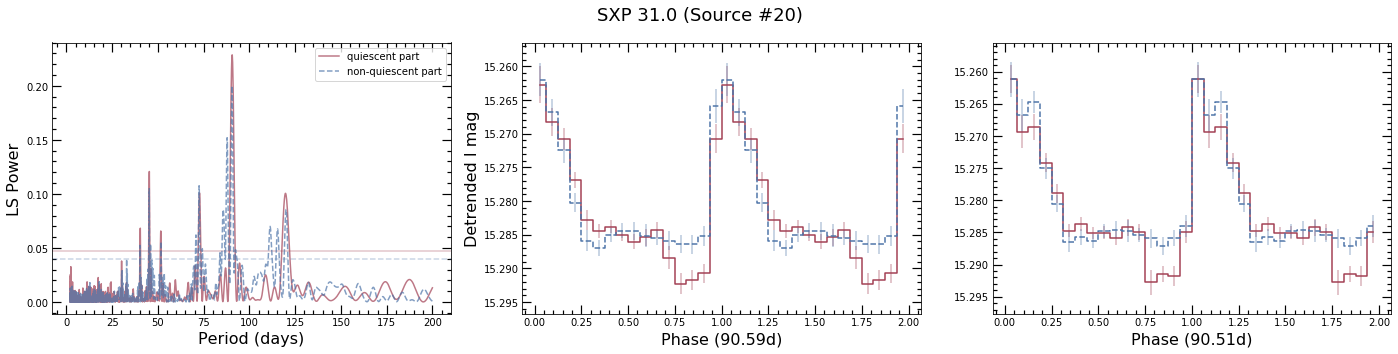

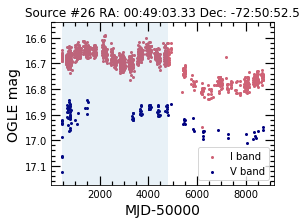

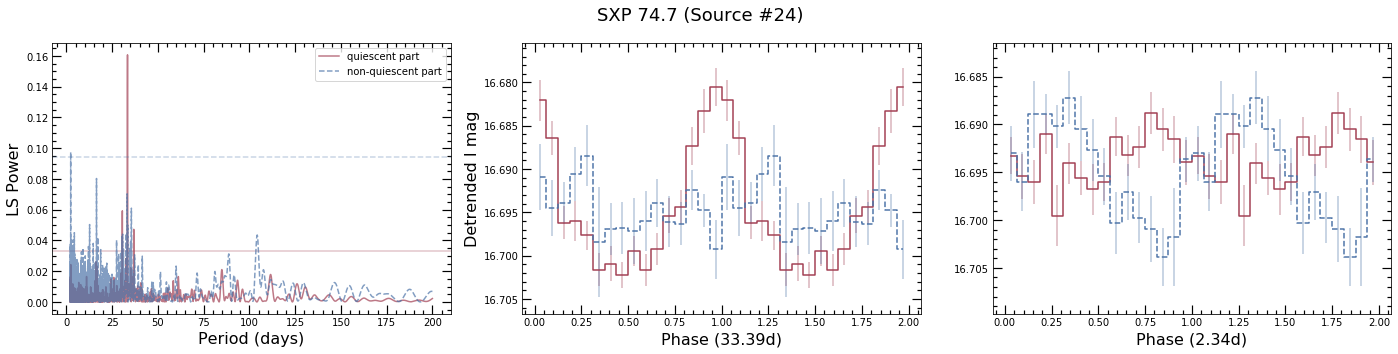

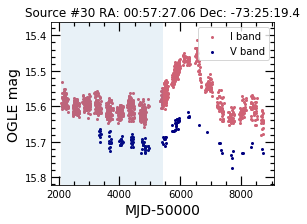

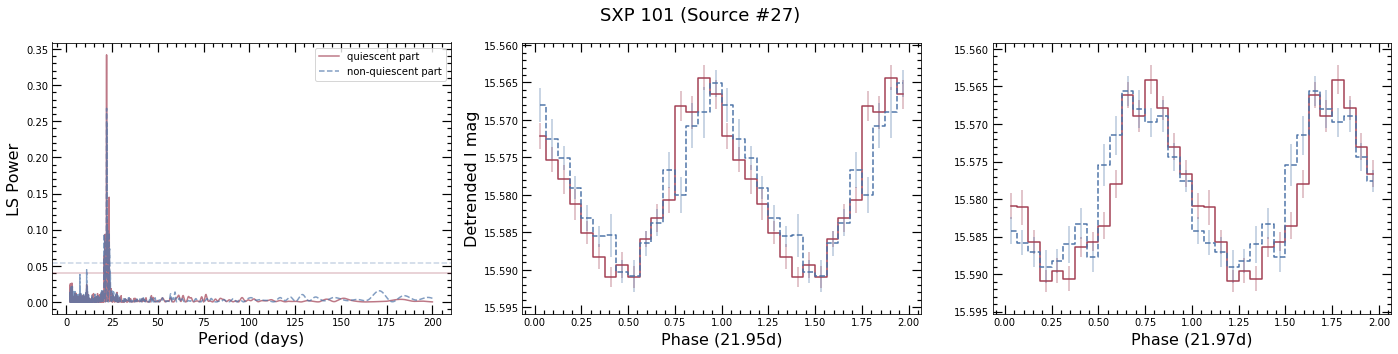

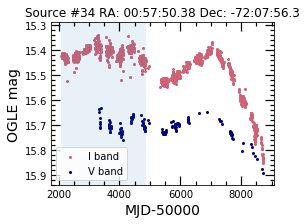

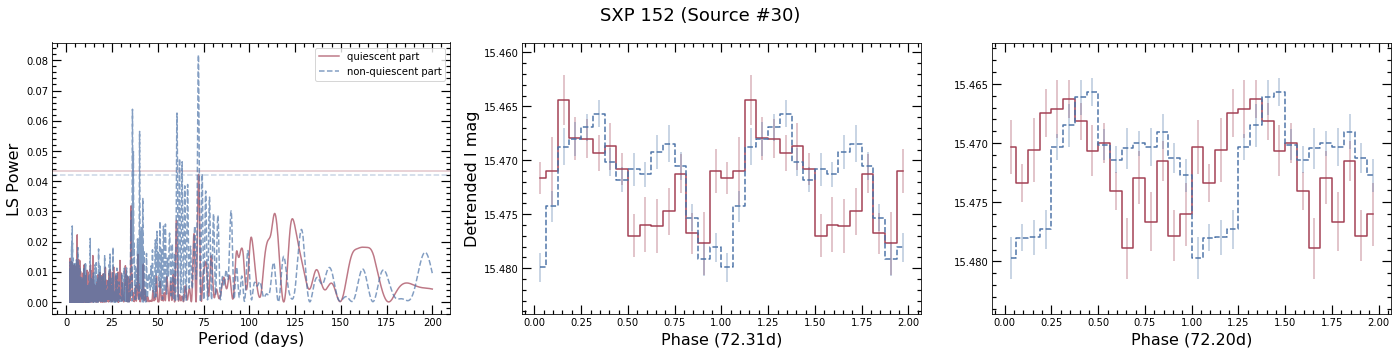

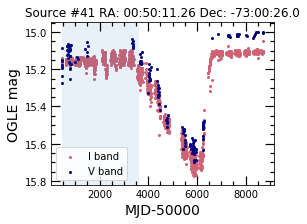

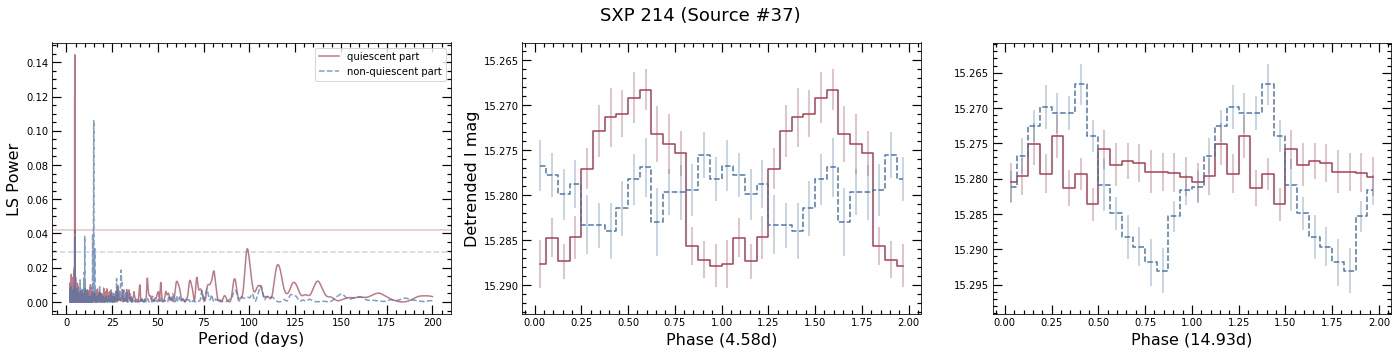

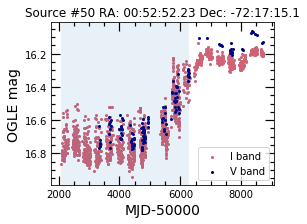

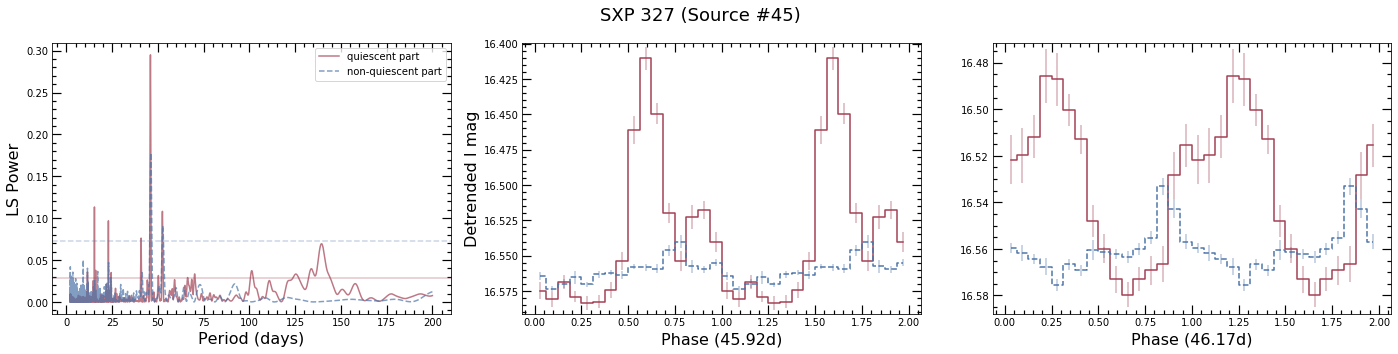

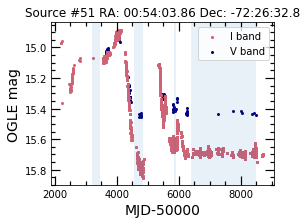

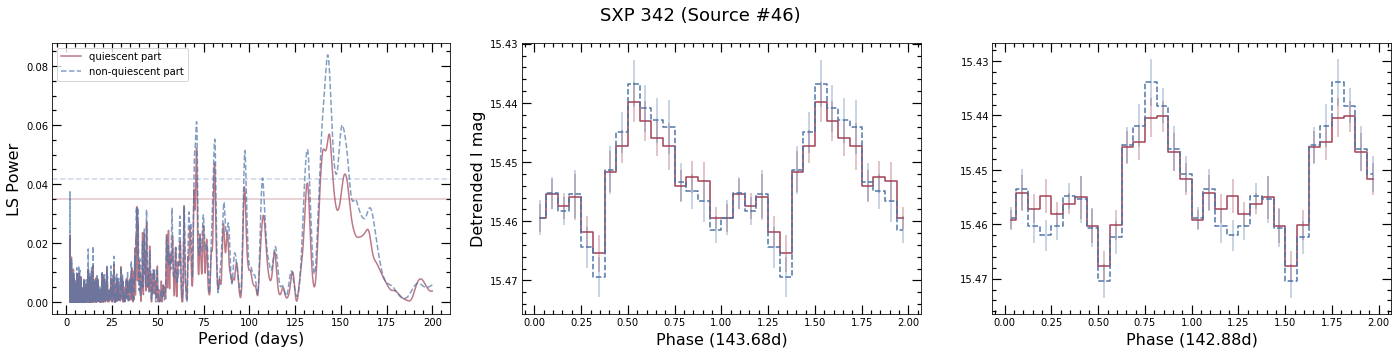

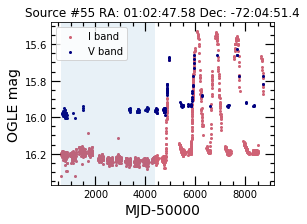

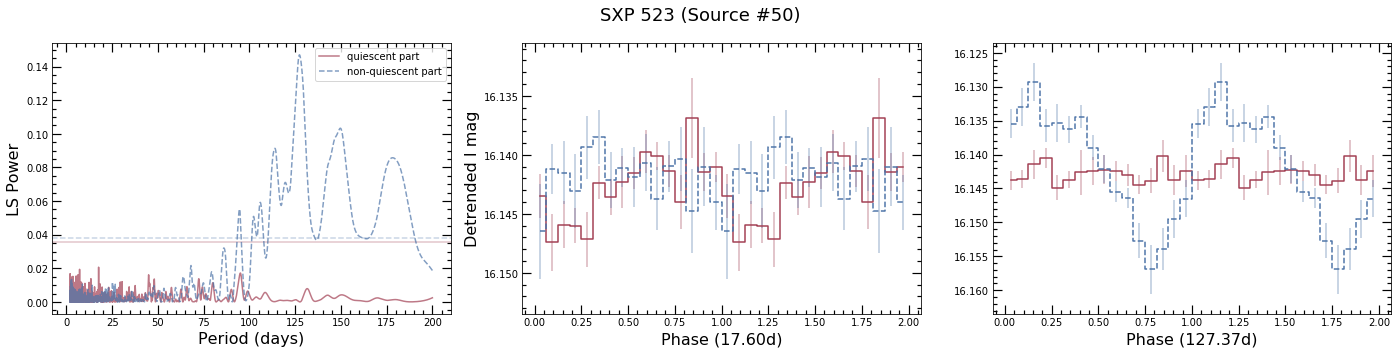

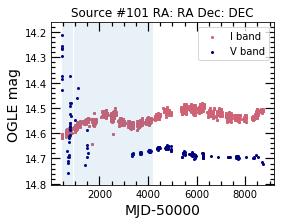

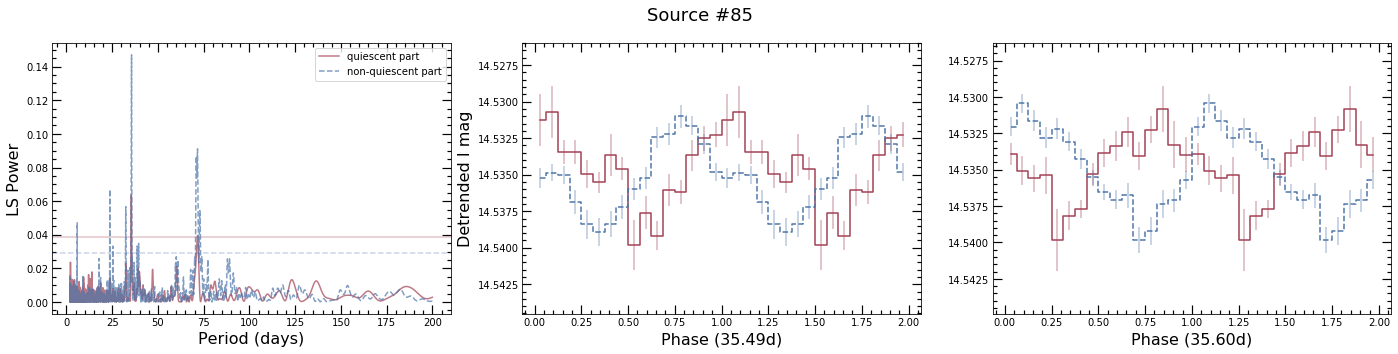

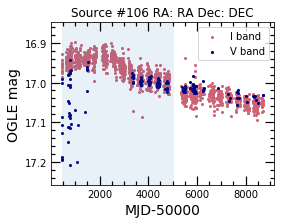

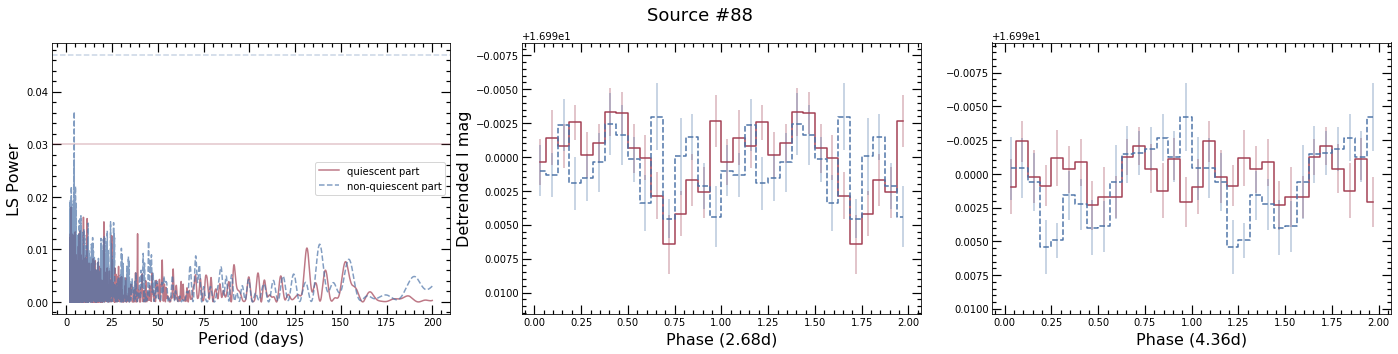

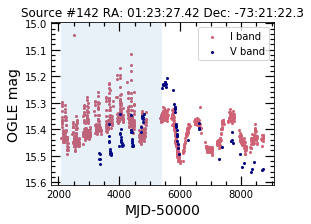

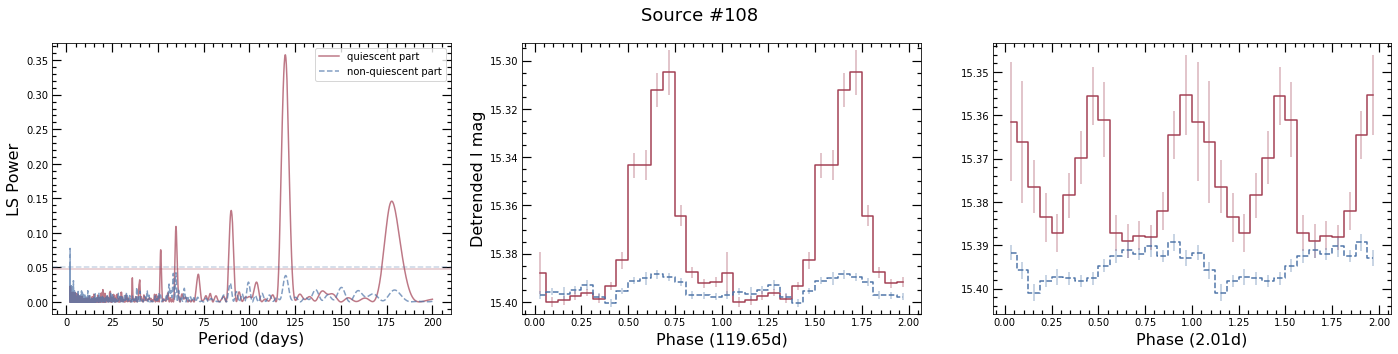

In [166]:
for i in np.array(qui['src_n']):
    quiescent_periodicity(i,plotlc=True)